# 1. Mount Drive , Prepare Dataset

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
path = "/content/gdrive/My Drive/MINIST"

os.chdir(path)
os.listdir(path)

['train-images.idx3-ubyte',
 'train-labels.idx1-ubyte',
 't10k-images.idx3-ubyte',
 't10k-labels.idx1-ubyte']

In [3]:
import numpy as np 
import struct 
   
from PIL import Image 
import os 
 
def train():
    data_file = path+'/train-images.idx3-ubyte'
    data_file_size = 47040000
    data_file_size = str(data_file_size ) + 'B' 
       
    data_buf = open(data_file, 'rb').read() 
       
    magic, numImages, numRows, numColumns = struct.unpack_from('>IIII', data_buf, 0) 

    datas = struct.unpack_from('>' + data_file_size, data_buf, struct.calcsize('>IIII')) 
 
    datas = np.array(datas).astype(np.uint8).reshape( numImages, 1, numRows, numColumns) 
       
    label_file = path+'/train-labels.idx1-ubyte'
 
    label_file_size = 60000
    label_file_size = str(label_file_size) + 'B' 
       
    label_buf = open(label_file, 'rb').read() 
       
    magic, numLabels = struct.unpack_from('>II', label_buf, 0) 
    labels = struct.unpack_from('>' + label_file_size, label_buf, struct.calcsize('>II')) 
    labels = np.array(labels).astype(np.int64) 
       
    return datas,labels
 
 
 
def test():
    data_file = path+'/t10k-images.idx3-ubyte'
 
    data_file_size = 7840000
    data_file_size = str(data_file_size ) + 'B' 
       
    data_buf = open(data_file, 'rb').read() 
       
    magic, numImages, numRows, numColumns = struct.unpack_from('>IIII', data_buf, 0) 
    datas = struct.unpack_from('>' + data_file_size, data_buf, struct.calcsize('>IIII')) 
    datas = np.array(datas).astype(np.uint8).reshape( numImages, 1, numRows, numColumns) 
       
    label_file =path+ '/t10k-labels.idx1-ubyte'
 
    label_file_size = 10000
    label_file_size = str(label_file_size ) + 'B' 
       
    label_buf = open(label_file, 'rb').read() 
       
    magic, numLabels = struct.unpack_from('>II', label_buf, 0) 
    labels = struct.unpack_from('>' + label_file_size, label_buf, struct.calcsize('>II')) 
    labels = np.array(labels).astype(np.int64) 
       
    return datas,labels
 
 
if __name__ == '__main__':
    trimg,trlb = train()
    teimg,telb = test()
    print(trimg.shape)

(60000, 1, 28, 28)


# 2. Dataset和DataLoader

torch.Size([1, 28, 28])


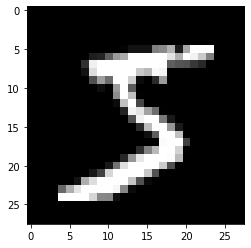

In [4]:
from torch.utils.data import Dataset,DataLoader
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
import torchvision

transf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5,0.5)]
)
class MINIST_ds(Dataset):
  def __init__(self,typ,transform=None):
    if typ == 'train':
      self.img = trimg
      self.lb = trlb
    else:
      self.img = teimg
      self.lb = telb  

    self.sp_len = self.img.shape[0]
    self.samples = []
    for idx in range(self.sp_len):
      mms = MinMaxScaler()
      onesample = mms.fit_transform(self.img[idx][0])
      if transform is not None:
        onesample = transform(onesample)
      self.samples.append((onesample,self.lb[idx]))
  def __len__(self):
    return self.sp_len
  
  def __getitem__(self,idx):
    return self.samples[idx]

DS = {x: MINIST_ds(x,transf) for x in ['train','val']}
DL = {x: DataLoader(DS[x], batch_size = 10, shuffle = True, num_workers = 0) for x in['train','val']}
print(DS['train'][0][0].shape)
plt.imshow(DS['train'][0][0][0],cmap='gray')

In [5]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
type(DS['train'][0][0])

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


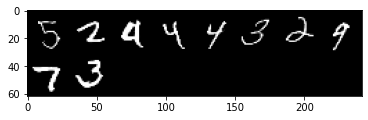

In [7]:
dataiter = iter(DL['train'])
images,labels = dataiter.next()
grid_img = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)),cmap='gray')

# 3. Convolutional Neural Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in DL[phase]:
                inputs = inputs.double()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


model_ft = Net()
model_ft = model_ft.double()
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
import time
import copy

dataset_sizes = {x: len(DS[x]) for x in ['train', 'val']}
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6748 Acc: 0.7796
val Loss: 0.1142 Acc: 0.9626

Epoch 1/24
----------
train Loss: 0.0926 Acc: 0.9711
val Loss: 0.0682 Acc: 0.9791

Epoch 2/24
----------
train Loss: 0.0609 Acc: 0.9810
val Loss: 0.0515 Acc: 0.9827

Epoch 3/24
----------
train Loss: 0.0474 Acc: 0.9850
val Loss: 0.0427 Acc: 0.9858

Epoch 4/24
----------
train Loss: 0.0381 Acc: 0.9884
val Loss: 0.0417 Acc: 0.9862

Epoch 5/24
----------
train Loss: 0.0317 Acc: 0.9900
val Loss: 0.0360 Acc: 0.9883

Epoch 6/24
----------
train Loss: 0.0258 Acc: 0.9918
val Loss: 0.0361 Acc: 0.9888

Epoch 7/24
----------
train Loss: 0.0160 Acc: 0.9956
val Loss: 0.0295 Acc: 0.9899

Epoch 8/24
----------
train Loss: 0.0141 Acc: 0.9964
val Loss: 0.0291 Acc: 0.9902

Epoch 9/24
----------
train Loss: 0.0134 Acc: 0.9964
val Loss: 0.0289 Acc: 0.9910

Epoch 10/24
----------
train Loss: 0.0128 Acc: 0.9968
val Loss: 0.0287 Acc: 0.9905

Epoch 11/24
----------
train Loss: 0.0124 Acc: 0.9969
val Loss: 0.0290 Acc: 0.9902

Ep